In [1]:
import sys
import os
import pickle
import keras
import datetime
import matplotlib
import copy

import numpy as np
import tensorflow as tf
from keras import backend as K
from tqdm import tqdm
from matplotlib import pyplot as plt



sys.path.append(os.path.abspath('../'))
import helpers
from helpers.data_generator import process_data, DataGenerator, AutoEncoderDataGenerator
from helpers.normalization import normalize, denormalize, renormalize
# from helpers.custom_losses import denorm_loss, hinge_mse_loss, percent_baseline_error, baseline_MAE
# from helpers.custom_losses import percent_correct_sign, baseline_MAE, normed_mse, mean_diff_sum_2, max_diff_sum_2, mean_diff2_sum2, max_diff2_sum2

##########
# set tf session
##########
config = tf.ConfigProto(intra_op_parallelism_threads=16,
                            inter_op_parallelism_threads=16,
                            allow_soft_placement=True,
                            device_count={'CPU': 8,
                                          'GPU': 1})
session = tf.Session(config=config)
K.set_session(session)


Using TensorFlow backend.


ModuleNotFoundError: No module named 'tensorflow'

# Metrics

In [2]:
##########
# metrics
##########
def mean_squared_error(true,pred):
    return np.mean((true-pred)**2)

def mean_absolute_error(true,pred):
    return np.mean(np.abs(true-pred))

def median_absolute_error(true,pred):
    return np.median(np.abs(true-pred))

def percentile25_absolute_error(true,pred):
    return np.percentile(np.abs(true-pred),25)

def percentile75_absolute_error(true,pred):
    return np.percentile(np.abs(true-pred),75)

def median_squared_error(true,pred):
    return np.median((true-pred)**2)

def percentile25_squared_error(true,pred):
    return np.percentile((true-pred)**2,25)

def percentile75_squared_error(true,pred):
    return np.percentile((true-pred)**2,75)

def huber_error(true,pred):
    return np.mean(np.where(np.abs(pred-true) < 0.7, 5*(pred - true)**2, 0.7*(np.abs(pred-true)-0.5*0.7)))

metrics = {'mean_squared_error':mean_squared_error,
          'mean_absolute_error':mean_absolute_error,
          'median_absolute_error':median_absolute_error,
          'percentile25_absolute_error':percentile25_absolute_error,
          'percentile75_absolute_error':percentile75_absolute_error,
          'median_squared_error':median_squared_error,
          'percentile25_squared_error':percentile25_squared_error,
          'percentile75_squared_error':percentile75_squared_error,
          'huber_error':huber_error
          }

# Load Model

In [3]:
##########
# load model and scenario
##########
base_path = os.path.expanduser('~')
folders = ['/run_results_10_02/']
           
for folder in folders:
    files =  [foo for foo in os.listdir(base_path+folder) if foo.endswith('.pkl')]
    for file in files:
        try:
            file_path = base_path + folder + file
            with open(file_path, 'rb') as f:
                scenario = pickle.load(f, encoding='latin1')
            
            
            model_path = file_path[:-11] + '.h5'
            if os.path.exists(model_path):
                model = keras.models.load_model(model_path, compile=False)
                print('loaded model: ' + model_path.split('/')[-1])
            else:
                print('no model for path:',model_path)
        except:
            pass

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/home/aiqtidar/.conda/envs/tfgpu/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/home/aiqtidar/.conda/envs/tfgpu/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/home/aiqtidar/.conda/envs/tfgpu/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/home/aiqtidar/.conda/envs/tfgpu/lib/python3.6/site-packages/traitlets/config/application.py", line 664, in launch_instance\n    app.start()', 'File "/home/aiqtidar/.conda/envs/tfgpu/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 563, in start\n    self.io_loop.start()', 'File "/home/aiqtidar/.conda/envs/tfgpu/lib/python3.6/site-packages/tornado/platf

# Overwrite Scenario?
This doesn't really make sense here but serves as a reminder to check if it exists

In [23]:
if 'evaluation_metrics' in scenario:
    print("evaluation_metrics found")
else:
    print("No evaluation_metrics found")

No evaluation_metrics found


# Generate Data

In [24]:
full_data_path = '/scratch/gpfs/jabbate/small_data.pkl'

traindata, valdata, normalization_dict = helpers.data_generator.process_data(full_data_path,
                                                                             scenario['sig_names'],
                                                                             scenario['normalization_method'],
                                                                             scenario['window_length'],
                                                                             scenario['window_overlap'],
                                                                             scenario['lookback'],
                                                                             scenario['lookahead'],
                                                                             scenario['sample_step'],
                                                                             scenario['uniform_normalization'],
                                                                             0.9, #scenario['train_frac'],
                                                                             0.1, #scenario['val_frac'],
                                                                             scenario['nshots'],
                                                                             0, #scenario['verbose']
                                                                             scenario['flattop_only'],
                                                                             randomize=False,
                                                                             pruning_functions=scenario['pruning_functions'],
                                                                             excluded_shots = scenario['excluded_shots'],
                                                                             delta_sigs = [],
                                                                             invert_q=scenario.setdefault('invert_q',False),
                                                                             val_idx = None)

            
valdata = helpers.normalization.renormalize(
    helpers.normalization.denormalize(
        valdata.copy(),normalization_dict, verbose=0),
    scenario['normalization_dict'],verbose=0)

train_generator = AutoEncoderDataGenerator(valdata,
                                scenario['batch_size'],
                                scenario['profile_names'],
                                scenario['actuator_names'],
                                scenario['scalar_names'],
                                scenario['lookback'],
                                scenario['lookahead'],
                                scenario['profile_downsample'],
                                scenario['state_latent_dim'],
                                shuffle =False)
            

# Train Model and get Predictions

In [25]:
predictions_arr = model.predict_generator(train_generator, verbose=0, workers=4, use_multiprocessing=True)

output_names = ['u_residual','x_residual','linear_system_residual']

predictions = {sig: arr for sig, arr in zip(output_names,predictions_arr)} 

InternalError: Blas GEMM launch failed : a.shape=(3, 4), b.shape=(4, 4), m=3, n=4, k=4
	 [[Node: ctrl_encoder_time_dist/dense_control_encoder/dense_45/MatMul = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false, _device="/job:localhost/replica:0/task:0/gpu:0"](ctrl_encoder_time_dist/dense_control_encoder/control_joiner/reshape_17/Reshape, dense_45/kernel/read)]]
	 [[Node: u_residual/sub/_417 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_1057_u_residual/sub", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'ctrl_encoder_time_dist/dense_control_encoder/dense_45/MatMul', defined at:
  File "/home/aiqtidar/.conda/envs/tfgpu/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/aiqtidar/.conda/envs/tfgpu/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/aiqtidar/.conda/envs/tfgpu/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/aiqtidar/.conda/envs/tfgpu/lib/python3.6/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/aiqtidar/.conda/envs/tfgpu/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()
  File "/home/aiqtidar/.conda/envs/tfgpu/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/aiqtidar/.conda/envs/tfgpu/lib/python3.6/asyncio/base_events.py", line 438, in run_forever
    self._run_once()
  File "/home/aiqtidar/.conda/envs/tfgpu/lib/python3.6/asyncio/base_events.py", line 1451, in _run_once
    handle._run()
  File "/home/aiqtidar/.conda/envs/tfgpu/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/aiqtidar/.conda/envs/tfgpu/lib/python3.6/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/aiqtidar/.conda/envs/tfgpu/lib/python3.6/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/aiqtidar/.conda/envs/tfgpu/lib/python3.6/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/aiqtidar/.conda/envs/tfgpu/lib/python3.6/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/aiqtidar/.conda/envs/tfgpu/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 361, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/aiqtidar/.conda/envs/tfgpu/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/aiqtidar/.conda/envs/tfgpu/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 268, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/aiqtidar/.conda/envs/tfgpu/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/aiqtidar/.conda/envs/tfgpu/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 541, in execute_request
    user_expressions, allow_stdin,
  File "/home/aiqtidar/.conda/envs/tfgpu/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/aiqtidar/.conda/envs/tfgpu/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 300, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/aiqtidar/.conda/envs/tfgpu/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/aiqtidar/.conda/envs/tfgpu/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2855, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/aiqtidar/.conda/envs/tfgpu/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2881, in _run_cell
    return runner(coro)
  File "/home/aiqtidar/.conda/envs/tfgpu/lib/python3.6/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/aiqtidar/.conda/envs/tfgpu/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/aiqtidar/.conda/envs/tfgpu/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3249, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/aiqtidar/.conda/envs/tfgpu/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-20-2df4ccaf1782>", line 18, in <module>
    model = keras.models.load_model(model_path, compile=False)
  File "/home/aiqtidar/.conda/envs/tfgpu/lib/python3.6/site-packages/keras/models.py", line 270, in load_model
    model = model_from_config(model_config, custom_objects=custom_objects)
  File "/home/aiqtidar/.conda/envs/tfgpu/lib/python3.6/site-packages/keras/models.py", line 347, in model_from_config
    return layer_module.deserialize(config, custom_objects=custom_objects)
  File "/home/aiqtidar/.conda/envs/tfgpu/lib/python3.6/site-packages/keras/layers/__init__.py", line 55, in deserialize
    printable_module_name='layer')
  File "/home/aiqtidar/.conda/envs/tfgpu/lib/python3.6/site-packages/keras/utils/generic_utils.py", line 144, in deserialize_keras_object
    list(custom_objects.items())))
  File "/home/aiqtidar/.conda/envs/tfgpu/lib/python3.6/site-packages/keras/engine/topology.py", line 2535, in from_config
    process_node(layer, node_data)
  File "/home/aiqtidar/.conda/envs/tfgpu/lib/python3.6/site-packages/keras/engine/topology.py", line 2492, in process_node
    layer(input_tensors[0], **kwargs)
  File "/home/aiqtidar/.conda/envs/tfgpu/lib/python3.6/site-packages/keras/engine/topology.py", line 619, in __call__
    output = self.call(inputs, **kwargs)
  File "/home/aiqtidar/.conda/envs/tfgpu/lib/python3.6/site-packages/keras/layers/wrappers.py", line 213, in call
    y = self.layer.call(inputs, **kwargs)
  File "/home/aiqtidar/.conda/envs/tfgpu/lib/python3.6/site-packages/keras/engine/topology.py", line 2085, in call
    output_tensors, _, _ = self.run_internal_graph(inputs, masks)
  File "/home/aiqtidar/.conda/envs/tfgpu/lib/python3.6/site-packages/keras/engine/topology.py", line 2250, in run_internal_graph
    output_tensors = _to_list(layer.call(computed_tensors, **kwargs))
  File "/home/aiqtidar/.conda/envs/tfgpu/lib/python3.6/site-packages/keras/engine/topology.py", line 2085, in call
    output_tensors, _, _ = self.run_internal_graph(inputs, masks)
  File "/home/aiqtidar/.conda/envs/tfgpu/lib/python3.6/site-packages/keras/engine/topology.py", line 2235, in run_internal_graph
    output_tensors = _to_list(layer.call(computed_tensor, **kwargs))
  File "/home/aiqtidar/.conda/envs/tfgpu/lib/python3.6/site-packages/keras/layers/core.py", line 877, in call
    output = K.dot(inputs, self.kernel)
  File "/home/aiqtidar/.conda/envs/tfgpu/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 1076, in dot
    out = tf.matmul(x, y)
  File "/home/aiqtidar/.conda/envs/tfgpu/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py", line 1816, in matmul
    a, b, transpose_a=transpose_a, transpose_b=transpose_b, name=name)
  File "/home/aiqtidar/.conda/envs/tfgpu/lib/python3.6/site-packages/tensorflow/python/ops/gen_math_ops.py", line 1217, in _mat_mul
    transpose_b=transpose_b, name=name)
  File "/home/aiqtidar/.conda/envs/tfgpu/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/home/aiqtidar/.conda/envs/tfgpu/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2506, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/aiqtidar/.conda/envs/tfgpu/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1269, in __init__
    self._traceback = _extract_stack()

InternalError (see above for traceback): Blas GEMM launch failed : a.shape=(3, 4), b.shape=(4, 4), m=3, n=4, k=4
	 [[Node: ctrl_encoder_time_dist/dense_control_encoder/dense_45/MatMul = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false, _device="/job:localhost/replica:0/task:0/gpu:0"](ctrl_encoder_time_dist/dense_control_encoder/control_joiner/reshape_17/Reshape, dense_45/kernel/read)]]
	 [[Node: u_residual/sub/_417 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_1057_u_residual/sub", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


# Generate True Output

In [ ]:
true_output = {sig:[] for sig in output_names}
for i in range(len(train_generator)):
    sample = train_generator[i]
    for sig in output_names:
        true_output[sig].append(sample[1][sig])
true_output = {sig:np.concatenate(true_output[sig],axis=0) for sig in output_names}
      

# Write the evaulation Matrix

In [ ]:
evaluation_metrics = {}
for metric_name,metric in metrics.items():
    s = 0
    for sig in output_names:
        key = sig + '_' + metric_name
        val = metric(true_output[sig],predictions[sig])
        s += val
        evaluation_metrics[key] = val
        print(key)
        print(val)
    evaluation_metrics[metric_name] = s

scenario['evaluation_metrics'] = evaluation_metrics
if 'date' not in scenario:
    scenario['date'] = datetime.datetime.strptime(scenario['runname'].split('_')[-2],'%d%b%y-%H-%M')


with open(file_path,'wb+') as f:
    pickle.dump(copy.deepcopy(scenario),f)

print('saved evaluation metrics')
print(evaluation_metrics)


# Import and additional Library for generating graphs

In [10]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials
from keras.models import Model
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import pickle
import keras
import tensorflow as tf
from keras import backend as K
import sys
import os
import time
sys.path.append(os.path.abspath('../'))
import helpers
from helpers.custom_losses import normed_mse, mean_diff_sum_2, max_diff_sum_2, mean_diff2_sum2, max_diff2_sum2

import copy
from helpers.normalization import normalize, denormalize, renormalize
import scipy
from tqdm import tqdm

# Some Plotting Conventions

In [11]:
matplotlib_colors = [(0.1215, 0.4667, 0.7058), # blue
                     (1.0000, 0.4980, 0.0549), # orange
                     (0.1725, 0.6275, 0.1725), # green
                     (0.8392, 0.1529, 0.1568), # red
                     (0.5804, 0.4039, 0.7412), # violet
                     (0.4980, 0.4980, 0.4980), # grey
                     (0.0902, 0.7450, 0.8117)] # cyan

matlab_colors=[(0.0000, 0.4470, 0.7410), # blue
               (0.8500, 0.3250, 0.0980), # reddish orange
               (0.9290, 0.6940, 0.1250), # yellow
               (0.4940, 0.1840, 0.5560), # purple
               (0.4660, 0.6740, 0.1880), # light green
               (0.3010, 0.7450, 0.9330), # cyan
               (0.6350, 0.0780, 0.1840)] # dark red

colorblind_colors = [(0.0000, 0.4500, 0.7000), # blue
                     (0.8359, 0.3682, 0.0000), # vermillion
                     (0.0000, 0.6000, 0.5000), # bluish green
                     (0.9500, 0.9000, 0.2500), # yellow
                     (0.3500, 0.7000, 0.9000), # sky blue
                     (0.8000, 0.6000, 0.7000), # reddish purple
                     (0.9000, 0.6000, 0.0000)] # orange

dashes = [(1.0, 0.0, 0.0, 0.0, 0.0, 0.0), # solid
          (3.7, 1.6, 0.0, 0.0, 0.0, 0.0), # dashed
          (1.0, 1.6, 0.0, 0.0, 0.0, 0.0), # dotted
          (6.4, 1.6, 1.0, 1.6, 0.0, 0.0), # dot dash
          (3.0, 1.6, 1.0, 1.6, 1.0, 1.6), # dot dot dash
          (6.0, 4.0, 0.0, 0.0, 0.0, 0.0), # long dash
          (1.0, 1.6, 3.0, 1.6, 3.0, 1.6)] # dash dash dot

from matplotlib import rcParams, cycler
matplotlib.rcdefaults()
rcParams['font.family'] = 'DejaVu Serif'
rcParams['mathtext.fontset'] = 'cm'
rcParams['font.size'] = 12
rcParams['figure.facecolor'] = (1,1,1,1)
rcParams['figure.figsize'] = (16,8)
rcParams['figure.dpi'] = 96
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['axes.labelsize'] =  'large'
rcParams['axes.titlesize'] = 'x-large'
rcParams['lines.linewidth'] = 2.5
rcParams['lines.solid_capstyle'] = 'round'
rcParams['lines.dash_capstyle'] = 'round'
rcParams['lines.dash_joinstyle'] = 'round'
rcParams['xtick.labelsize'] = 'large'
rcParams['ytick.labelsize'] = 'large'

color_cycle = cycler(color=colorblind_colors)
dash_cycle = cycler(dashes=dashes)
rcParams['axes.prop_cycle'] =  color_cycle

# Load files if not already loaded

In [19]:
#os.chdir('/projects/EKOLEMEN/profile_predictor/run_results_06_29/')
os.chdir('..')
print (os.path.abspath(os.curdir))
os.chdir(os.path.expanduser('~/run_results_10_02/'))

files = [foo for foo in os.listdir() if '.pkl' in foo]
files


for f in files:
    with open(f,'rb') as f:
        scenario = pickle.load(f,encoding='latin1')

#sorted(scenario.keys())

/home/aiqtidar


# Bar Chart of Results

Evaluation Metrics not in scenario


IndexError: cannot do a non-empty take from an empty axes.

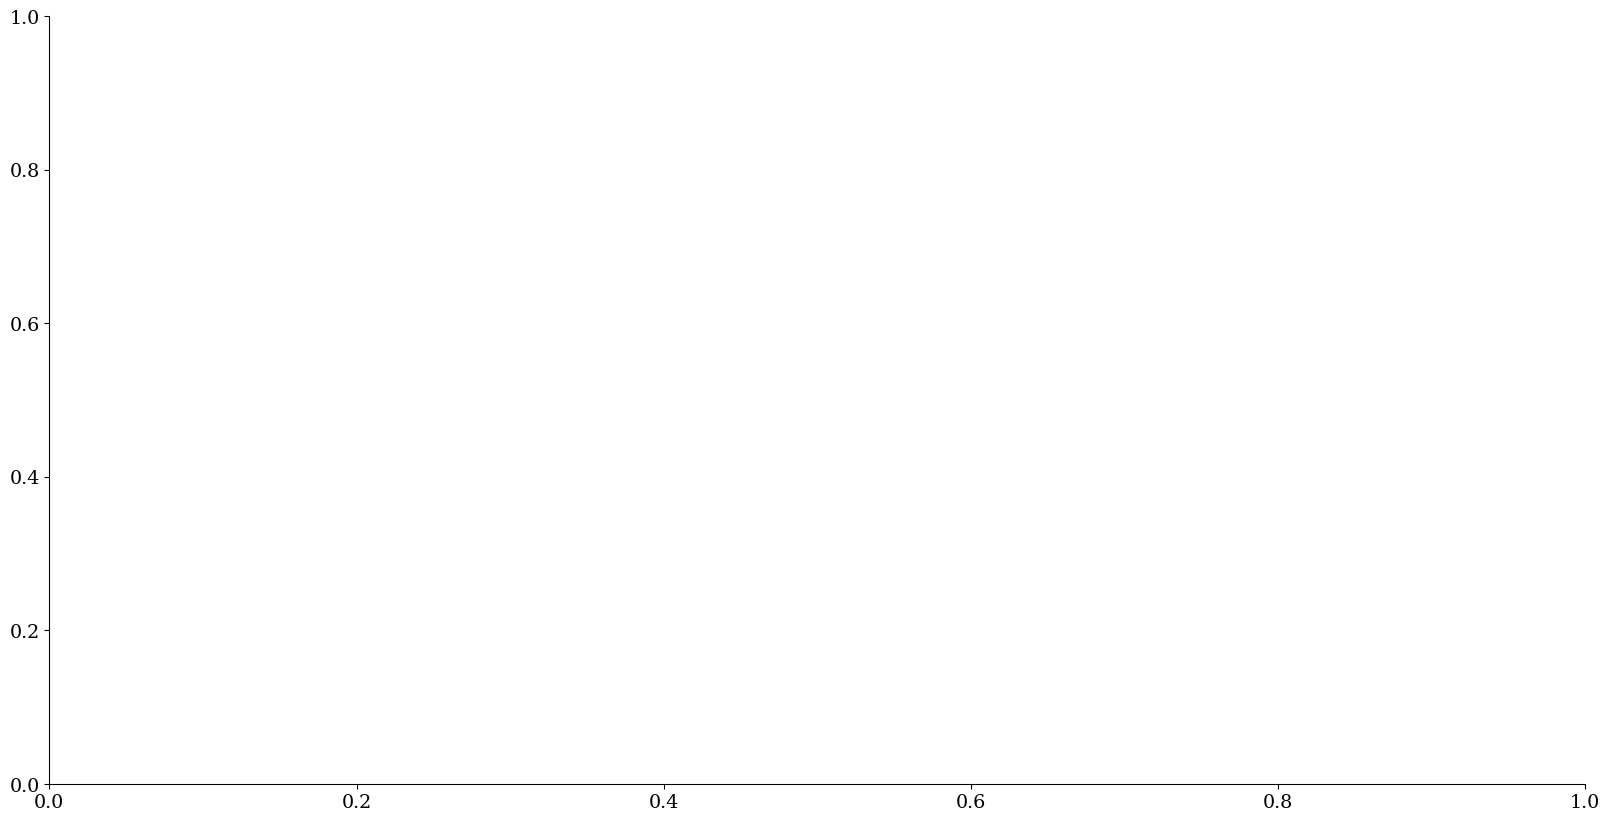

In [17]:
temp_mse = []
temp_mae = []
dens_mse = []
x_huber = []
u_huber = []
res_huber = []


if 'evaluation_metrics' not in scenario:
    print("Evaluation Metrics not in scenario")
if 'evaluation_metrics' in scenario:
            temp_mse.append(scenario['evaluation_metrics']['x_residual_mean_squared_error'])
            dens_mse.append(scenario['evaluation_metrics']['u_residual_mean_squared_error'])
            temp_mae.append(scenario['evaluation_metrics']['linear_system_residual_mean_squared_error'])
            x_huber.append(scenario['evaluation_metrics']['x_residual_huber_error'])
            u_huber.append(scenario['evaluation_metrics']['u_residual_huber_error'])
            res_huber.append(scenario['evaluation_metrics']['linear_system_residual_huber_error'])
                
op = lambda x: np.percentile(x,0) #Best case
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
labels = ['x_residual_mse', 'u_residual_mse', 'linear_system_residual_mse', 'x_huber', 'u_huber','linear_huber']
bars = [op(temp_mse),op(dens_mse),op(temp_mae),op(x_huber),op(u_huber),op(res_huber)]
ax.bar(labels,bars)
plt.show()